In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np

#For plotting
from matplotlib import pyplot as plt
import matplotlib as mpl
plt.rcParams["animation.html"] = "jshtml"
mpl.rcParams['figure.facecolor'] = 'white'
plt.rcParams["image.origin"] = "lower"


from gpuocean.SWEsimulators import CDKLM16
from gpuocean.utils import Common, IPythonMagic, PlotHelper

In [2]:
%cuda_context_handler gpu_ctx

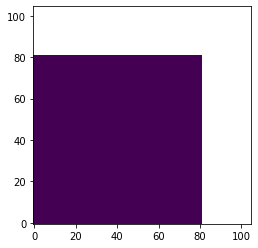

In [3]:
sim_args = {
"gpu_ctx": gpu_ctx,
"nx": 100, "ny": 100,
"dx": 200.0, "dy": 200.0,
"dt": 1,
"g": 9.81,
"f": 0.0,
"coriolis_beta": 0.0,
"r": 0.0
}

dataShape = (sim_args["ny"] + 4, 
             sim_args["nx"] + 4)

H = np.ones((dataShape[0]+1, dataShape[1]+1), dtype=np.float32) * 60.0
H = np.ma.masked_array(H)
landmask = np.zeros_like(H)
landmask[:, 82:] = 1
landmask[82:, :] = 1
H.mask = landmask
plt.imshow(H)

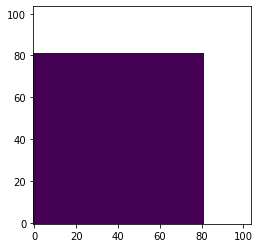

In [4]:
eta0 = np.ma.masked_array(np.ones(dataShape, dtype=np.float32), mask=H.mask[:-1,:-1])*1.0
hu0 =  np.ma.masked_array(np.zeros(dataShape, dtype=np.float32), mask=H.mask[:-1,:-1])
hv0 =  np.ma.masked_array(np.zeros(dataShape, dtype=np.float32), mask=H.mask[:-1,:-1])
plt.imshow(hu0)


In [5]:
data_args = {"H": H, "eta0": eta0, "hu0": hu0, "hv0": hv0, "rk_order": 2}
sim = CDKLM16.CDKLM16(**data_args, **sim_args)


In [6]:
sim.step(100)

100.0

max(abs(  eta, hu, hv )): 1.9073486e-06 1.5513102e-05 1.5513102e-05


Text(0.5, 1.0, 'hu')

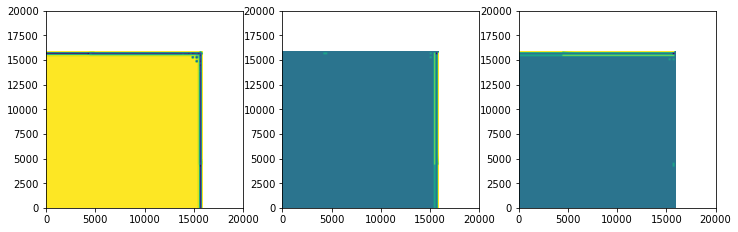

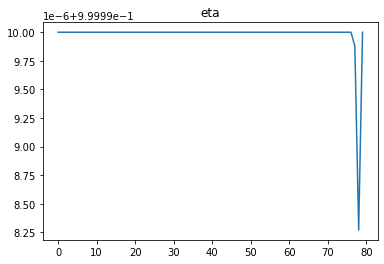

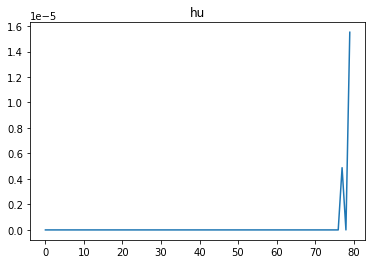

In [7]:
eta, hu, hv = sim.download(interior_domain_only=True)
fig = plt.figure(figsize=(12,8))
domain_extent = [0, sim.nx*sim.dx, 0, sim.ny*sim.dy]
ax_eta = plt.subplot(1,3,1)
ax_eta.imshow(eta, extent=domain_extent)

ax_u = plt.subplot(1,3,2)
ax_u.imshow(hu,extent=domain_extent)
    
ax_v = plt.subplot(1,3,3)
ax_v.imshow(hv, extent=domain_extent)

print("max(abs(  eta, hu, hv )):", np.max(np.abs(eta-np.max(eta0))), np.max(np.abs(hu)), np.max(np.abs(hv)))

fig = plt.figure()
plt.plot(eta[20, :])
plt.title("eta")
fig = plt.figure()
plt.plot(hu[20, :])
plt.title("hu")


# Wave with and without landmask

(81, 81)


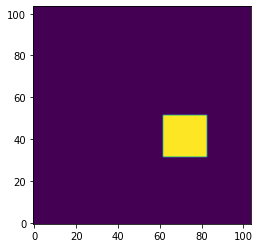

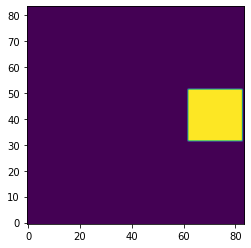

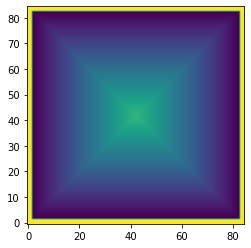

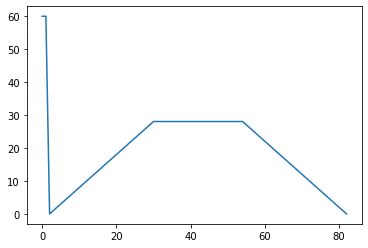

In [8]:
sim_args_wall = {
"gpu_ctx": gpu_ctx,
"nx": 80, "ny": 80,
"dx": 200.0, "dy": 200.0,
"dt": 1,
"g": 9.81,
"f": 0.0,
"coriolis_beta": 0.0,
"r": 0.0
}

dataShape_wall = (sim_args_wall["ny"] + 4, 
                  sim_args_wall["nx"] + 4)

H = np.ones((dataShape[0]+1, dataShape[1]+1), dtype=np.float32) * 60.0
H = np.ma.masked_array(H)
landmask = np.zeros_like(H)
landmask[:, 82:] = 1
landmask[82:, :] = 1
H.mask = landmask

H_wall = np.ones((dataShape_wall[0]+1, dataShape_wall[1]+1), dtype=np.float32) * 60.0
eta0_wall = np.zeros(dataShape_wall, dtype=np.float32)
hu0_wall =  np.zeros(dataShape_wall, dtype=np.float32)
hv0_wall =  np.zeros(dataShape_wall, dtype=np.float32)

eta0_land = np.ma.masked_array(np.zeros(dataShape, dtype=np.float32)) #, mask=H.mask[1:,1:])

#eta0_wall[32:52, 32:52] = 1.0
#eta0_land[32:52, 32:52] = 1.0
eta0_wall[32:52, 62:83] = 1.0
eta0_land[32:52, 62:83] = 1.0
#eta0_wall[:, 32:52] = 1.0
#eta0_land[:, 32:52] = 1.0 
#eta0_land += 1.0
#eta0_wall += 1.0
plt.imshow(eta0_land.data)
fig = plt.figure()
plt.imshow(eta0_wall)

new_H = np.zeros((81,81))
print(new_H.shape)
for j in range(81):
    for i in range(81):
        new_H[j, i] = 40.1 - max(np.abs(j-40), np.abs(i - 40))

H_wall[2:-2, 2:-2] = new_H
H[2:-22, 2:-22] = new_H

fig = plt.figure()
plt.imshow(H_wall)
fig = plt.figure()
plt.plot(H[:, 30])

data_args_wall = {"H": H_wall, "eta0": eta0_wall, "hu0": hu0_wall, "hv0": hv0_wall, "rk_order": 2}
data_args_land = {"H": H, "eta0": eta0_land, "hu0": hu0, "hv0": hv0, "rk_order": 2}

In [14]:
sim_args_wall["f"] = 0.0#012
sim_args["f"] = 0.0#012

sim_wall = CDKLM16.CDKLM16(**data_args_wall, **sim_args_wall)
sim_land = CDKLM16.CDKLM16(**data_args_land, **sim_args)

#T = 200
#
T = 470*20
sim_wall.step(T)
sim_land.step(T)

eta_land, hu_land, hv_land = sim_land.download(interior_domain_only=True)
eta_wall, hu_wall, hv_wall = sim_wall.download(interior_domain_only=True)

fig = plt.figure(figsize=(7,7))
ax_eta = plt.subplot(1,3,1)
ax_eta.imshow(eta_land[20:60,75:85])
ax_u = plt.subplot(1,3,2)
ax_u.imshow(hu_land[20:60, 75:85])
ax_v = plt.subplot(1,3,3)
sp_v = ax_v.imshow(hv_land[20:60, 75:85])

fig = plt.figure(figsize=(7,7))
ax_eta = plt.subplot(1,3,1)
ax_eta.imshow(eta_wall[20:60,75:85])
ax_u = plt.subplot(1,3,2)
ax_u.imshow(hu_wall[20:60, 75:85])
ax_v = plt.subplot(1,3,3)
sp_v = ax_v.imshow(hv_wall[20:60, 75:85])



400.0 400.0 412.1839
init, wall,     land


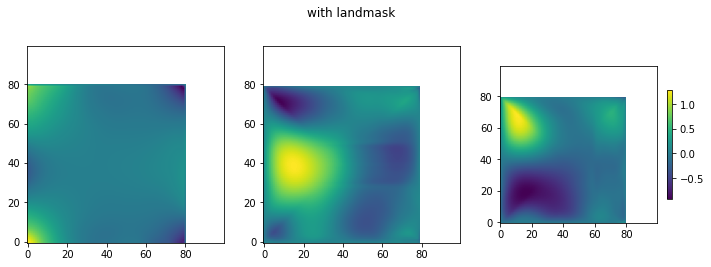

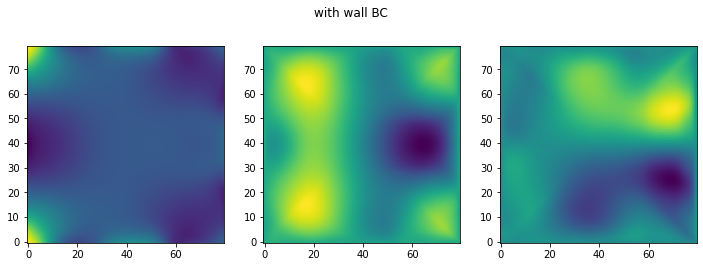

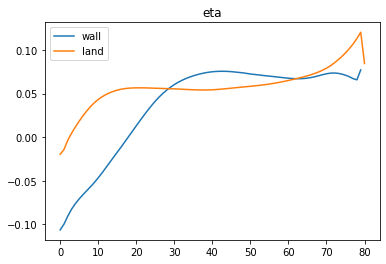

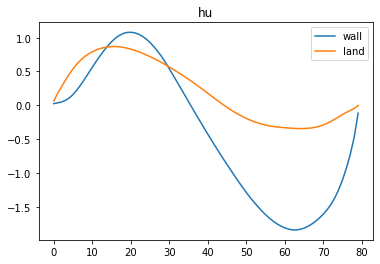

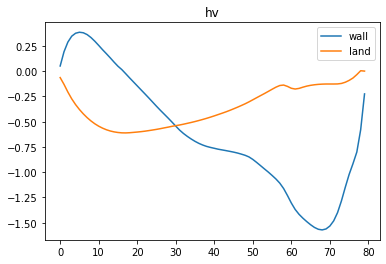

In [15]:
fig = plt.figure(figsize=(12,4))
ax_eta = plt.subplot(1,3,1)
ax_eta.imshow(eta_land)
ax_u = plt.subplot(1,3,2)
ax_u.imshow(hu_land)
ax_v = plt.subplot(1,3,3)
sp_v = ax_v.imshow(hv_land)
plt.colorbar(sp_v, ax= ax_v, shrink=0.5)
plt.suptitle("with landmask")


fig = plt.figure(figsize=(12,4))
ax_eta = plt.subplot(1,3,1)
ax_eta.imshow(eta_wall)
ax_u = plt.subplot(1,3,2)
ax_u.imshow(hu_wall)
ax_v = plt.subplot(1,3,3)
ax_v.imshow(hv_wall)
plt.suptitle("with wall BC")


fig = plt.figure()
plt.plot(eta_wall[30, :], label="wall")
plt.plot(eta_land[30, :], label="land")
plt.legend()
plt.title("eta")

fig = plt.figure()
plt.plot(hu_wall[30, :], label="wall")
plt.plot(hu_land[30, :], label="land")
plt.legend()
plt.title("hu")

fig = plt.figure()
plt.plot(hv_wall[30, :], label="wall")
plt.plot(hv_land[30, :], label="land")
#plt.plot([30, 30], [-1,1])
#plt.plot([50, 50], [-1,1])
plt.legend()
plt.title("hv")

print(np.sum(eta0_wall[2:-2, 2:-2]), np.sum(eta_wall[:80, :80]), np.sum(eta_land[:80, :80]))
print("init, wall,     land")

# 400.0 400.00415 393.75104 <-- without the PR
# 400.0 400.00415 395.49026 <-- original PR
# 400.0 400.00415 395.48944 <-- with -vp
# 400.0 400.00415 395.488   <-- with 5*(-vp)


In [11]:
eta_land.shape

(100, 100)

Text(0.5, 1.0, 'hu land')

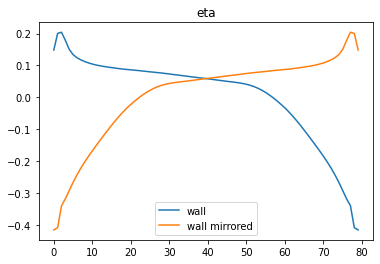

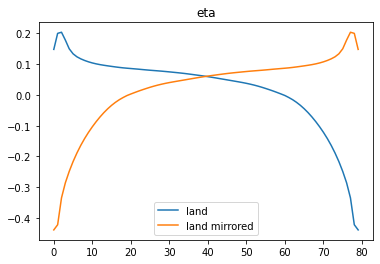

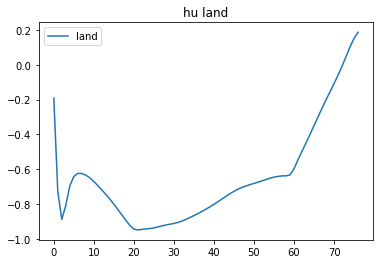

In [12]:
fig = plt.figure()
plt.plot(eta_wall[20, :], label="wall")
plt.plot(np.arange(79, -1, -1), eta_wall[20, :], label="wall mirrored")
plt.legend()
plt.title("eta")

fig = plt.figure()
plt.plot(eta_land[20, :80], label="land")
plt.plot(np.arange(79, -1, -1), eta_land[20, :80], label="land mirrored")
plt.legend()
plt.title("eta")

fig = plt.figure()
plt.plot(hu_land[20, :77], label="land")
#plt.plot(np.arange(79, -1, -1), eta_land[20, :80], label="land mirrored")
plt.legend()
plt.title("hu land")



1e+20

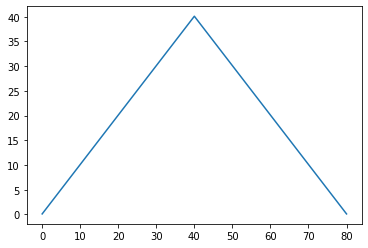

In [13]:

new_H = np.zeros((81,81))
#for j in range(81):
for i in range(81):
    new_H[:, i] = 40.1 - np.abs(i - 40)

plt.plot(new_H[23, :])

eta0_land.get_fill_value()